In [56]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeManila, FakeToronto, FakeJakartaV2, FakeProvider
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import QDrift, LieTrotter, SuzukiTrotter

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import os
import sys
from datetime import date
import pathlib
import inspect
import time
import glob
from qiskit import execute
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..')) # qrc_surrogate
sys.path.append(module_path)
fig_path = f'{module_path}/figs'


from src.feedforward import QExtremeLearningMachine, CPolynomialFeedforward
from src.rewinding import QRewindingRC, QRewindingStatevectorRC,  QRewindingRC_Neat
from src.data import DataSource

from iqm.qiskit_iqm import IQMFakeAdonis, IQMFakeApollo
from iqm.qiskit_iqm import IQMProvider,transpile_to_IQM,optimize_single_qubit_gates


In [50]:
def Simulated_Reservoir(nsteps_in,enc):
    
    Meas_List=[] # we need to keep this for set-up of the final circuits.

    # We produce a custom version of the "manual constuction".
    Manual_Layout_List=[]
    nmem = 3
    nsteps=nsteps_in
    for step in range(nsteps):
        memory_qubits=list(range(nmem))
        data_qubits=list(range(nmem+step*2,nmem+(step+1)*2))
        Manual_Layout_List+= [memory_qubits + data_qubits]
    print(Manual_Layout_List)
    if max(Manual_Layout_List[-1])>nmem+2*nsteps:
        print('warning: circuit too large for backend!')
        qc = QuantumCircuit(Manual_Layout_List[-1],Manual_Layout_List[-1])
    else:
    #Overall circuit!
        #qc = QuantumCircuit(nmem+2*nsteps, nmem+2*nsteps)
         qc = QuantumCircuit(20, nmem+2*nsteps)

    #And the current circuit.
    c_circuit = QuantumCircuit(5,2)



        

    #Manually create a swap:
    cSWAP=QuantumCircuit(2,0)
    cSWAP.swap(0,1)
    #gSWAP=transpile(cSWAP, basis_gates=['r', 'cz'], optimization_level = 0)

    #For the automatic circuits, we use the qiskit gates and allow transpilation.

        

    theta_list=[Parameter('theta_'+str(i)) for i in range(len(Manual_Layout_List[0]))]
    for step in range(nsteps): # Loop over all steps used..:
        c_qubits=Manual_Layout_List[step]
        # Add undefined inputs:
        qn = 0 # qubit counter for loop
        for c in range(1):
            for d in range(int(2 /1)): # dimx
                phi_c = Parameter('phi_'+str(step)+'_'+str(qn))
                
                #print(step,qn,c_qubits[self.memory_size+0*self.dimxqc+self.qin[qn]])
                if True:
                    match enc:
                        case 'x':
                            qc.rx(theta=phi_c,qubit=c_qubits[3+[0,1][qn]])
                        case 'y':
                            qc.ry(theta=phi_c, qubit=c_qubits[3+[0,1][qn]])
                        case 'z':
                            qc.rz(phi=phi_c, qubit=c_qubits[3+[0,1][qn]])
                        case _:
                            raise Warning(f'Invalid encaxes={self.encaxes}')
                elif False: 
                    self.encaxes = ['ry', 'rz']
                    qc.h(qubit=self.memory_size+0*self.dimxqc+self.qin[qn])
                    qc.ry(np.arctan(phi_c) + np.pi/4, qubit=self.memory_size+step*self.dimxqc+self.qin[qn])
                    qc.rz(np.arctan(phi_c**2) + np.pi/4, qubit=self.memory_size+step*self.dimxqc+self.qin[qn])

                    
                else:
                    raise Warning(f'Invalid enctype {self.enctype}')
                qn += 1
            
                

            
        for i in range(len(c_qubits)):
            #H
            qc.h(qubit=c_qubits[i])
            #qc.r(theta=np.pi,phi=0, qubit=c_qubits[i])



        # CZ
        for i in range(len(c_qubits)-1):
            qc.cz(control_qubit=c_qubits[i],target_qubit=c_qubits[i+1])
        qc.cz(control_qubit=c_qubits[-1],target_qubit=c_qubits[0])

        #XROT
        for i in range(len(c_qubits)):
            #X
            
            qc.rx(theta=theta_list[i],qubit=c_qubits[i])
            #H
            qc.h(qubit=c_qubits[i])
            #qc.r(theta=np.pi,phi=0, qubit=c_qubits[i])

            

            




        #We will keep track of which measurements to perform here:
        if 2 > 0:
            adj_meas=[k + 3 for k in [0,1]]
            
            Meas_List  += [[Manual_Layout_List[step][k] for k in adj_meas]]

    #In the last step, we measure ALL qubits.
    Meas_List=Manual_Layout_List[-1]

    #We now have to transpile the circuit!
    ## define the circuit to be run on the hardware
    #opt_level = self.opt_level ## defines the optimization level


    #Not necessary...

    #if (self.QPU == 'Apollo'):
    #    qubit_names = ["QB3", "QB8", "QB4", "QB9", "QB13", "QB14", "QB5", "QB10", "QB15", "QB6", "QB11", "QB16", "QB7", "QB12", "QB17", "QB18", "QB19", "QB20", "QB1", "QB2"]
    #elif (self.QPU == 'Adonis'):
    #    qubit_names = ["QB1", "QB3", "QB2", "QB4", "QB5"]

    # We allow qiskit to perform transpilation!
    #tqc = transpile(qc,backend=self.backend,optimization_level=opt_level)
    # We need to see how the qubits have been permuted:
    #perm_lib_qiskit=tqc.layout.initial_layout
    # This is the wrong form for our purposes: we need to swap it:

    #meas_mapping={perm_lib_qiskit[k].index:k for k in range(self.backend.num_qubits)}

    #self.all_meas=[[meas_mapping[i] for i in k] for k in self.all_meas]

    return qc, Meas_List

In [51]:
[circ,meas]=Simulated_Reservoir(2,'y')

[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6]]


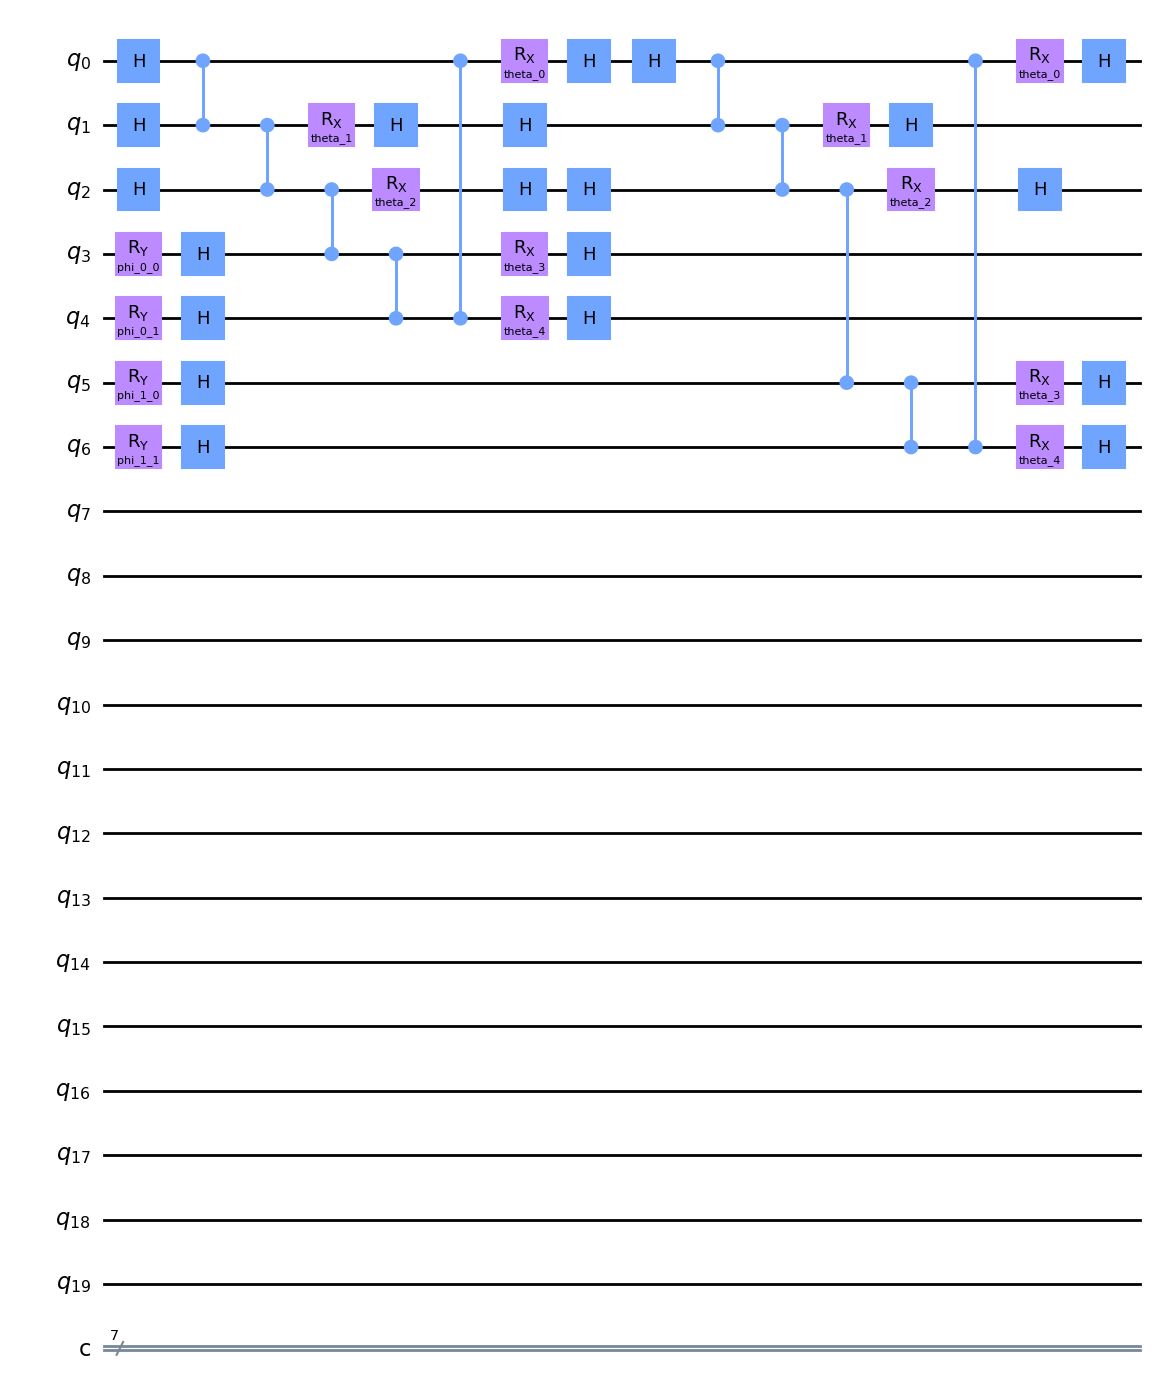

In [52]:
circ.draw('mpl')

In [57]:
circ_trans=transpile(circ,backend=IQMFakeApollo(),optimization_level=3)

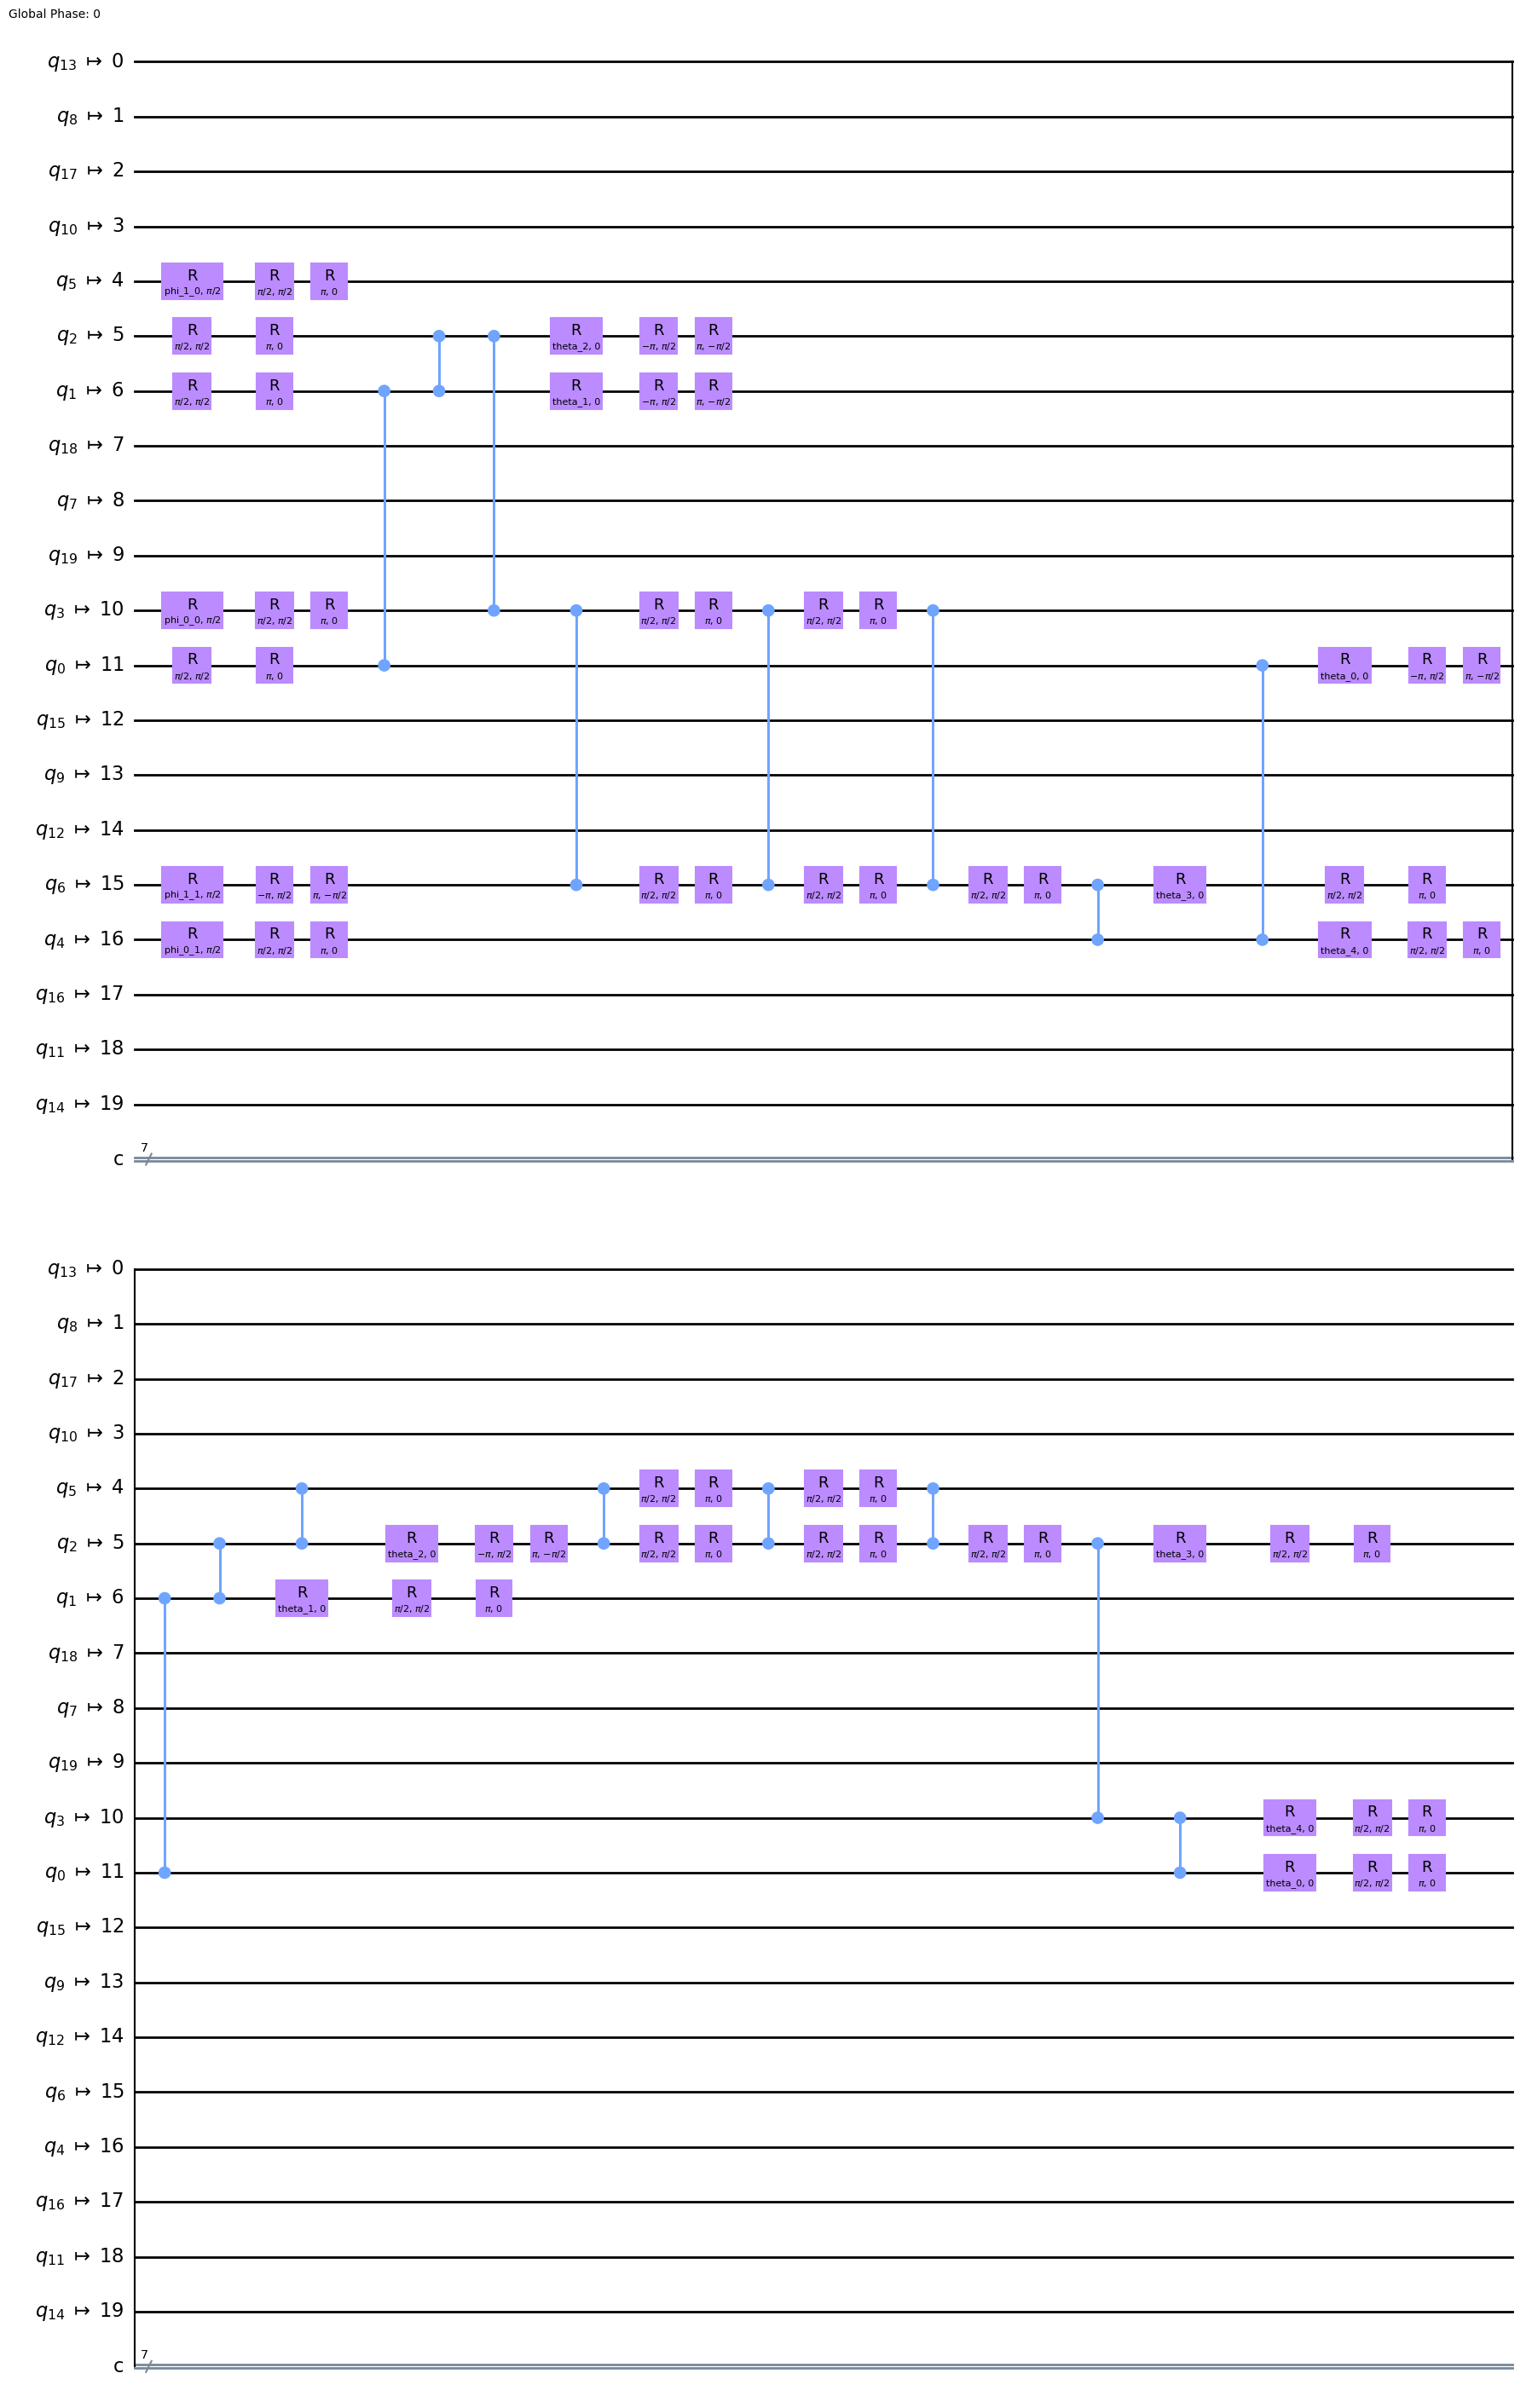

In [58]:
circ_trans.draw('mpl')

In [92]:
circ_sq=optimize_single_qubit_gates(circ_trans,drop_final_rz=False)

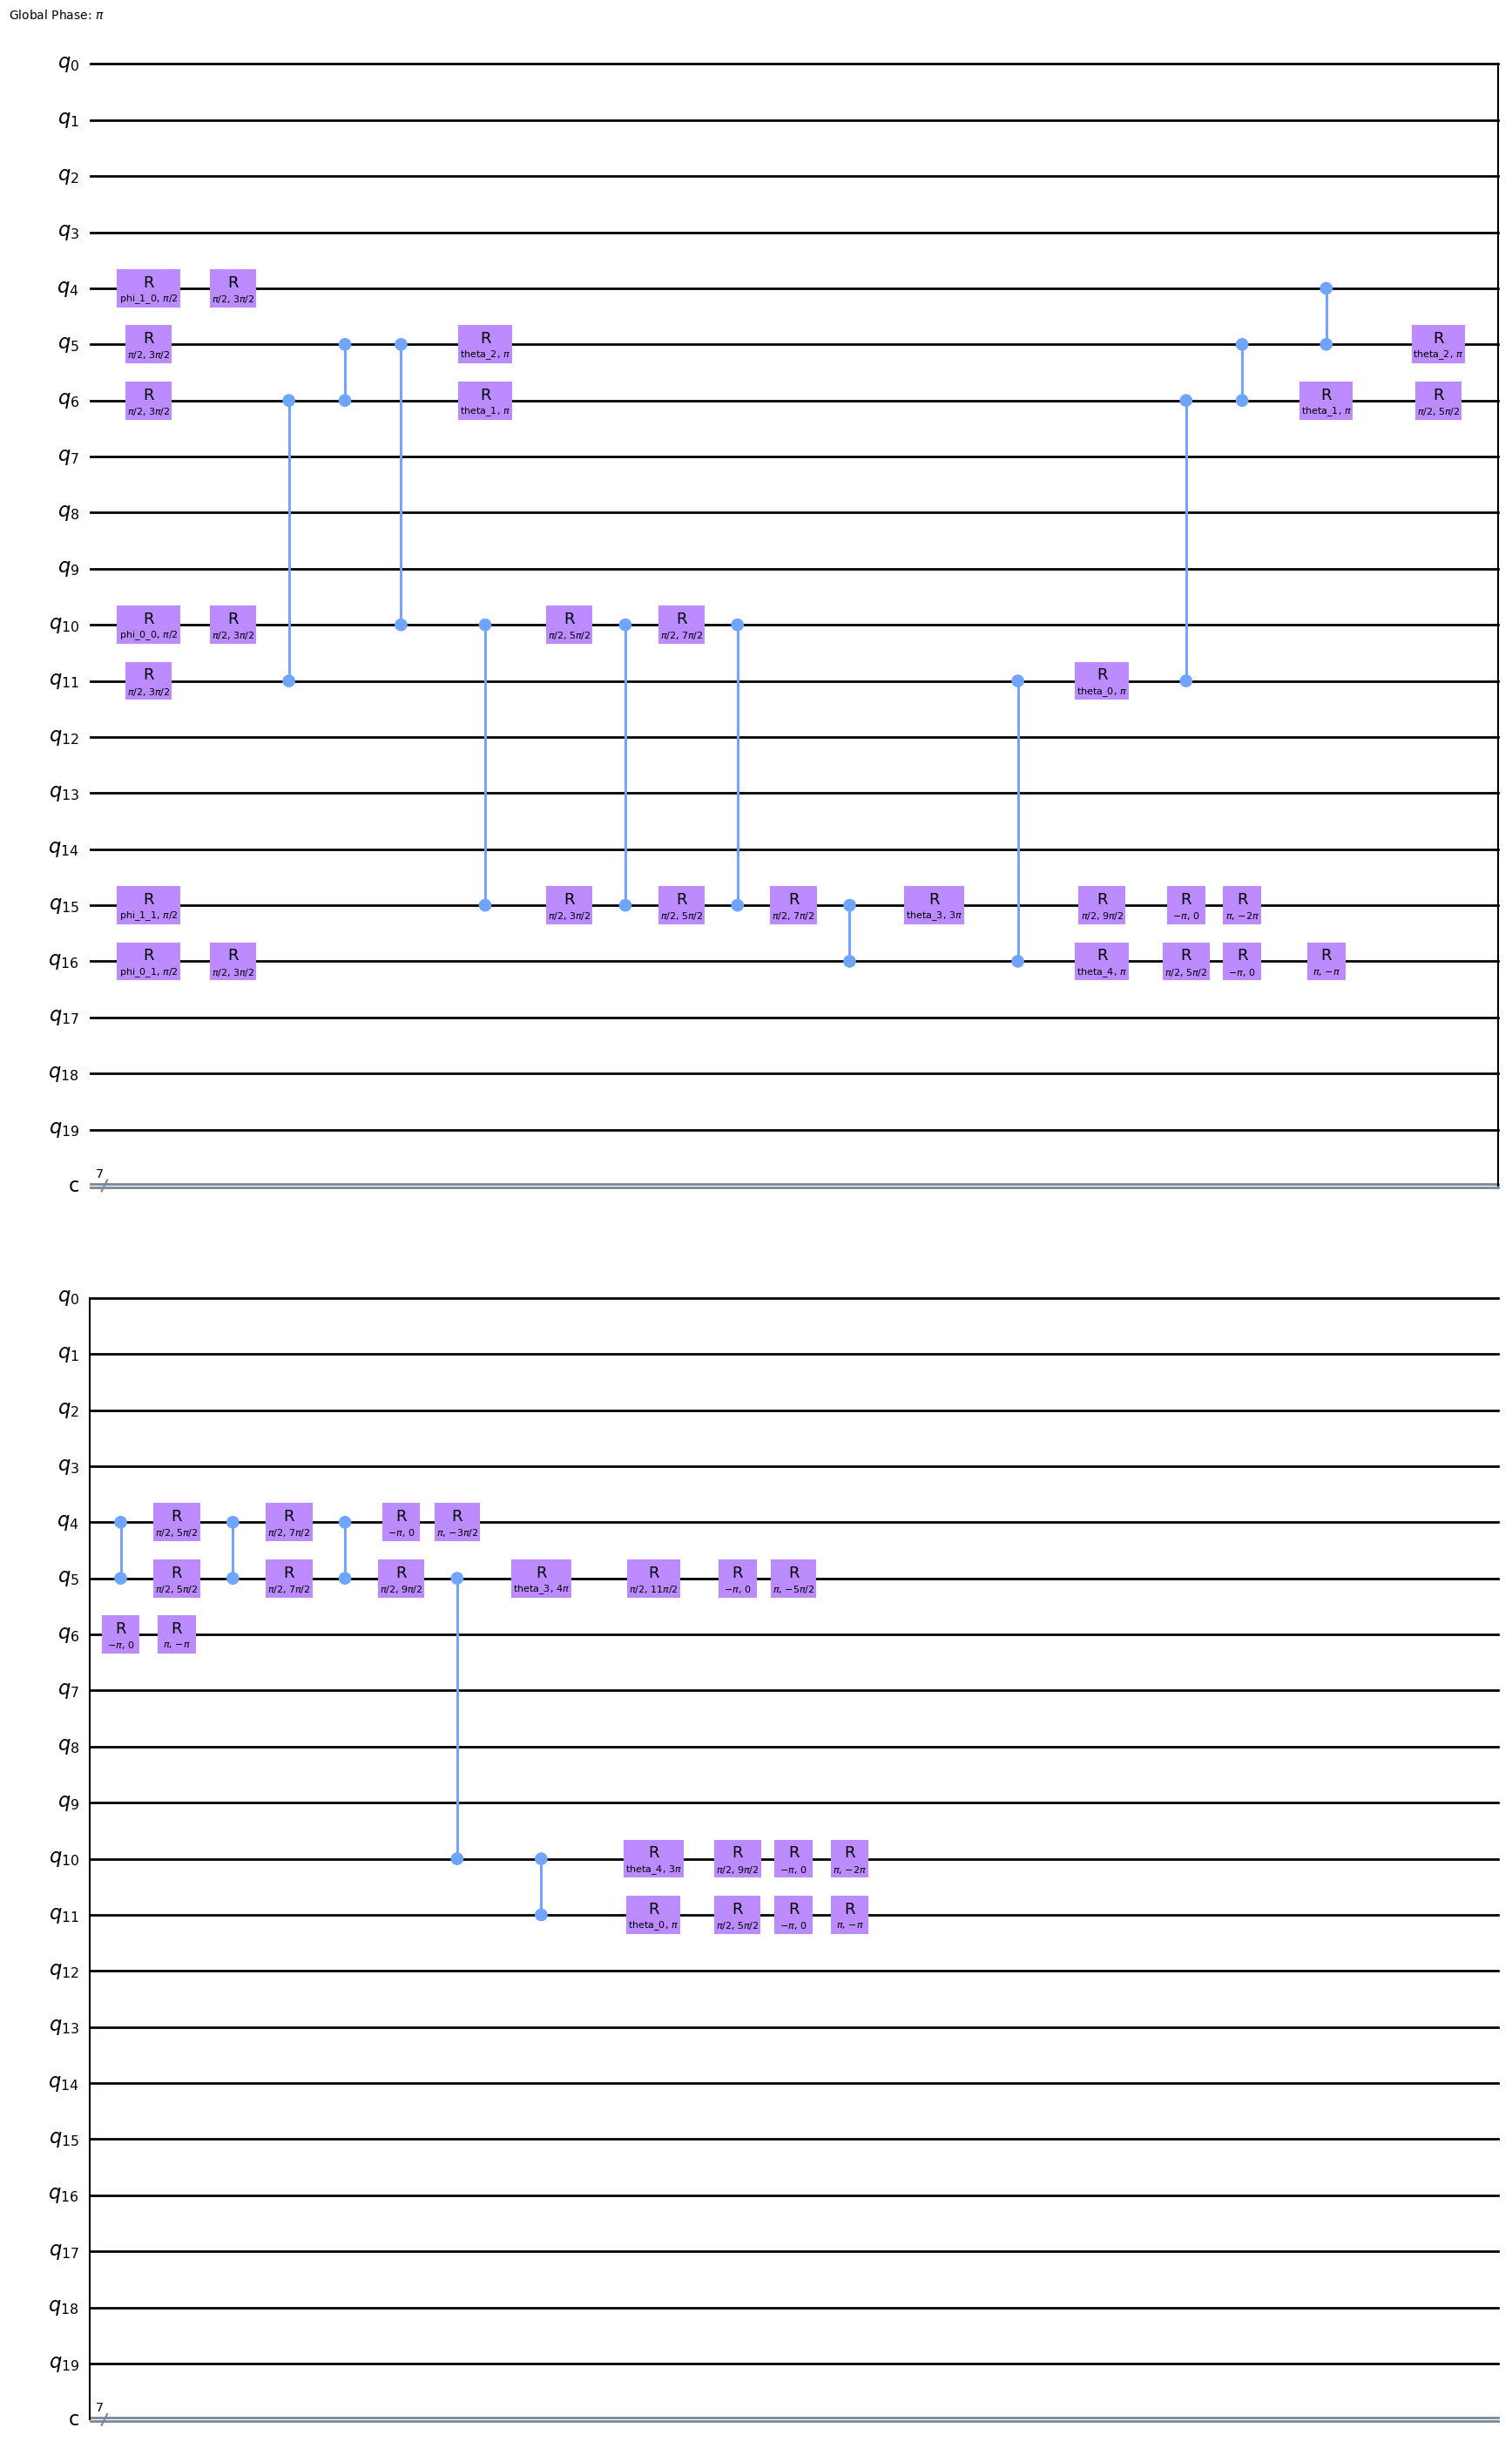

In [93]:
circ_sq.draw('mpl')

In [94]:
phi=np.array([[np.pi*0.8,0.7],[np.pi*0.8,0.7]])
theta=np.array([2.84,-4.5,9.08,9.57,6.37])
param_map_trans={k.name:k for k in circ_trans.parameters}
param_map_sq={k.name:k for k in circ_sq.parameters}
shape_phi=phi.shape

phi_assignment_trans={param_map_trans['phi_%s_%s' % (k,s)]:phi[k,s] for k in range(shape_phi[0]) for s in range(shape_phi[1])}
theta_assignment_trans={param_map_trans['theta_%s' % k]:theta[k] for k in range(len(theta))}

phi_assignment_sq={param_map_sq['phi_%s_%s' % (k,s)]:phi[k,s] for k in range(shape_phi[0]) for s in range(shape_phi[1])}
theta_assignment_sq={param_map_sq['theta_%s' % k]:theta[k] for k in range(len(theta))}

explicit_val_trans=circ_trans.assign_parameters(phi_assignment_trans)
explicit_val_trans=explicit_val_trans.assign_parameters(theta_assignment_trans)
explicit_val_trans.save_statevector()
backend = AerSimulator(method='statevector')
job = execute(explicit_val_trans, backend=backend, shots=1, memory=True)
job_result = job.result()
strans=job_result.get_statevector(explicit_val_trans)

explicit_val_sq=circ_sq.assign_parameters(phi_assignment_sq)
explicit_val_sq=explicit_val_sq.assign_parameters(theta_assignment_sq)
explicit_val_sq.save_statevector()
backend = AerSimulator(method='statevector')
job_sq = execute(explicit_val_sq, backend=backend, shots=1, memory=True)
job_result_sq = job_sq.result()
ssq=job_result_sq.get_statevector(explicit_val_sq)


In [40]:
from qiskit.quantum_info import Pauli

In [102]:
from itertools import product

for 

In [112]:
SampleOp=Pauli(('I'*4+'Z'+'I'*15)[::-1])
SampleOp

SampleOp=Pauli(('I'*10+'Z'+'I'*(19-10))[::-1])
SampleOp

SampleOp=Pauli(('I'*4+'Z'+'I'*5+'Z'+'I'*(18-9))[::-1])
SampleOp



Pauli('IIIIIIIIIZIIIIIZIIII')

In [113]:
(strans.expectation_value(SampleOp),ssq.expectation_value(SampleOp))

(-6.245004513516506e-17, 1.3877787807814457e-17)

In [101]:
np.linalg.norm(strans-ssq)

2.1297377779211123e-15

In [100]:
strans[0],ssq[0]

((0.04661704162940212+0.12030221252773572j),
 (0.04661704162940167+0.12030221252773567j))